In [4]:
try:
  # pydot-ng is a fork of pydot that is better maintained.
  import pydot_ng as pydot
except ImportError:
  # pydotplus is an improved version of pydot
  try:
    import pydotplus as pydot
  except ImportError:
    # Fall back on pydot if necessary.
    try:
      import pydot
    except ImportError:
      pydot = None


def check_pydot():
  """Returns True if PyDot and Graphviz are available."""
  if pydot is None:
    return False
  try:
    # Attempt to create an image of a blank graph
    # to check the pydot/graphviz installation.
    pydot.Dot.create(pydot.Dot())
    return True
  except (OSError, pydot.InvocationException):
    return False

In [8]:
pydot.Dot.create(pydot.Dot())

FileNotFoundError: [WinError 2] "dot" not found in path.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio
import tifffile as tiff 
import pickle
from pathlib import Path
from skimage import io

from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np

import re


TODO
- Implement Tracking validation of deeepcell to Imaris
  - Make sure index is correct
  - Implemet reproducible pipeline

In [30]:
def result_csv_to_table(table_path,start,crop):
    table_name = table_path.stem
    df_deep = pd.read_csv(table_path)
    df_length = df_deep.shape[1]
    crop_dict = {0:(0,0),1:(0,520),2:(704,0),3:(704,520)}
    #TODO Check it out
    df_d = df_deep.drop(columns = 'Unnamed: 0').fillna("A")
    # re.findall("\d+\.\d+",x)
    numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
    rx = re.compile(numeric_const_pattern, re.VERBOSE)
    df_d = df_d.applymap(lambda x: [float(i) for i in rx.findall(x)])
    df_d = df_d.applymap(lambda y: np.nan if len(y)<2 else y)
    for i in range(df_length):
        #TODO Make sure
        real_idx = start + i*2 + 1
        df_d.rename(columns = {f'{i}':real_idx},inplace=True)
    df_u = df_d.unstack().reset_index()
    df_u.dropna(inplace=True)
    # TODO Add crop data
    if table_name =='centroids':
        x_add, y_add = crop_dict[crop]
        df_u['X'] = df_u[0].map(lambda x :x_add + x[1])
        df_u['Y'] = df_u[0].map(lambda x : y_add + x[0])
    elif table_name == 'embeddings':
        df_u['Embeddings'] = df_u[0]
    elif table_name == 'morphologies':
        df_u['Area'] = df_u[0].map(lambda x : x[0])
        df_u['Major Axis'] = df_u[0].map(lambda x : x[1])
        df_u['Minor Axis'] = df_u[0].map(lambda x : x[2])
    else:
        return
    df_f = df_u.rename(columns={'level_0':'Time','level_1':'ID'}).drop(columns=0)  
    return df_f

In [31]:
def folder_result_to_one_table(res_path:Path):
    res_name = res_path.stem
    res_well = res_name.split('_')[1]
    res_view = res_name.split('_')[2]
    res_start = int(res_name.split('start_')[1][0])
    res_crop = int(res_name.split('crop_')[1][0])
    df = pd.DataFrame()
    for res_csv in res_path.glob('*.csv'):
        df_res = result_csv_to_table(res_csv,res_start,res_crop)
        if df_res is None:
            continue
        df_res = df_res.set_index(['Time','ID'])
        df = pd.concat([df_res,df], axis=1)
    df['well'] = res_well
    df['view'] = res_view
    return df



In [5]:
# def result_to_track(res_path):
#     df = pd.read_csv(res_path)


In [148]:
all_res_path = Path(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new')
for res_folder in all_res_path.glob('*'):
    print(res_folder)
    folder_result_to_one_table(res_folder).to_csv(res_folder.joinpath('res_all_features.csv'))


C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_1_2022-09-06_18-26-14
C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_2_2022-09-06_18-29-13
C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_3_2022-09-06_18-33-24
C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_5_crop_0_2022-09-06_18-24-25


In [ ]:
# well = 'D2'
# view = '3'
# list(all_res_path.glob(f'*{well}_{view}*'))

In [175]:
df = pd.read_csv(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_3_2022-09-06_18-33-24\res_all_features.csv')
df

,Time,ID,Area,Major Axis,Minor Axis,Embeddings,X,Y,well,view
0,4,0,27.0,11.201383,3.076451,"[0.0, 1.7975739, 0.0, 0.0, 0.0, 0.06528136, 0....",1363.703700,520.814815,D2,1
1,4,1,171.0,15.093697,14.538408,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",750.192980,911.070200,D2,1
2,6,0,89.0,13.500052,8.644434,"[0.0, 0.87382585, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1364.876400,523.157303,D2,1
3,6,1,196.0,16.578730,15.158662,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",755.688774,910.030600,D2,1
4,6,2,76.0,10.866455,8.938723,"[0.0, 0.883108, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",741.513157,540.184210,D2,1
...,...,...,...,...,...,...,...,...,...,...
20525,186,737,100.0,12.385518,10.357710,"[0.0, 0.45853367, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...",1354.820000,790.570000,D2,1
20526,186,738,53.0,8.864541,7.694518,"[0.0, 1.3454757, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1266.226440,850.452820,D2,1
20527,186,739,47.0,13.369251,4.923783,"[0.0, 1.7573234, 0.0, 0.0, 0.0, 0.03556499, 0....",1405.595760,980.744700,D2,1
20528,186,740,126.0,13.211841,12.148284,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1400.642900,1031.968260,D2,1


In [50]:
df.groupby('ID').size().describe()

count    535.000000
mean      12.186916
std       10.079953
min        1.000000
25%        3.000000
50%       10.000000
75%       19.000000
max       42.000000
dtype: float64

In [49]:
# df['Embediings'] = df['Embediings'].map(lambda x : np.array(eval(x)))

In [7]:
# df['morpho_kinetic'] = str(df.drop(columns=['ID','Time','well','view','Embediings']).values.tolist())

In [176]:
df_k = df.drop(columns=['well','view','Embeddings','Area','Major Axis','Minor Axis'])
df_k

,Time,ID,X,Y
0,4,0,1363.703700,520.814815
1,4,1,750.192980,911.070200
2,6,0,1364.876400,523.157303
3,6,1,755.688774,910.030600
4,6,2,741.513157,540.184210
...,...,...,...,...
20525,186,737,1354.820000,790.570000
20526,186,738,1266.226440,850.452820
20527,186,739,1405.595760,980.744700
20528,186,740,1400.642900,1031.968260


In [75]:
# df_k.pivot(index=['ID','Time'] ,columns=['Time'], values=['X','Y'])

In [102]:
df_y = pd.pivot_table(df_k.drop(columns='X'),index='ID',columns='Time')
df_y

Y                                                            \
Time          3         5           7           9           11          13   
ID                                                                           
0      37.141890       NaN         NaN   38.296090         NaN   32.825397   
1      42.151684       NaN         NaN   42.301370   47.102566   41.915440   
2     168.647060       NaN  171.506110  173.642380  164.983200  165.780350   
3            NaN  18.37619   12.495335   25.226562   12.766173   12.469613   
4            NaN       NaN    4.054545         NaN         NaN         NaN   
..           ...       ...         ...         ...         ...         ...   
715          NaN       NaN         NaN         NaN         NaN         NaN   
716          NaN       NaN         NaN         NaN         NaN         NaN   
717          NaN       NaN         NaN         NaN         NaN         NaN   
718          NaN       NaN         NaN         NaN         NaN         NaN   
719          NaN       NaN         NaN         NaN         NaN         NaN   

                                                      ...              \
Time          15          17          19          21  ...          59   
ID                                                    ...               
0      33.669810   31.113333   32.865852         NaN  ...         NaN   
1      47.659737   38.338980   43.983452   38.350426  ...   49.753730   
2     173.343020  170.588240  175.524695  186.223770  ...  183.915500   
3      21.743046   12.358696   13.666023         NaN  ...   38.417393   
4            NaN         NaN         NaN         NaN  ...         NaN   
..           ...         ...         ...         ...  ...         ...   
715          NaN         NaN         NaN         NaN  ...         NaN   
716          NaN         NaN         NaN         NaN  ...         NaN   
717          NaN         NaN         NaN         NaN  ...         NaN   
718          NaN         NaN         NaN         NaN  ...         NaN   
719          NaN         NaN         NaN         NaN  ...         NaN   

                                                                             \
Time         63          67          71          75          79          83   
ID                                                                            
0           NaN         NaN         NaN         NaN         NaN         NaN   
1      59.40972   57.251614   59.278145   62.300655   66.496735   65.496735   
2     192.50993  193.725000  193.458600  183.969700  193.100000  191.091600   
3      47.74775   47.256200   48.450000   49.324505   69.744050   70.251430   
4           NaN         NaN         NaN         NaN         NaN         NaN   
..          ...         ...         ...         ...         ...         ...   
715         NaN         NaN         NaN         NaN         NaN         NaN   
716         NaN         NaN         NaN         NaN         NaN         NaN   
717         NaN         NaN         NaN         NaN         NaN         NaN   
718         NaN         NaN         NaN         NaN         NaN         NaN   
719         NaN         NaN         NaN         NaN         NaN         NaN   

                                         
Time          87         91          95  
ID                                       
0            NaN        NaN         NaN  
1      71.061646   73.95042   67.818184  
2     209.268520  199.62627  204.703380  
3      62.975000   62.90845   69.776535  
4            NaN        NaN         NaN  
..           ...        ...         ...  
715          NaN        NaN  451.148930  
716          NaN        NaN  468.689670  
717          NaN        NaN  495.969400  
718          NaN        NaN  170.941800  
719          NaN        NaN  483.025330  

[720 rows x 35 columns]

In [103]:
df_x = pd.pivot_table(df_k.drop(columns='Y'),index='ID',columns='Time')
df_x

X                                                           \
Time          3          5          7          9           11          13   
ID                                                                          
0      75.898650        NaN        NaN  68.396645         NaN   89.063490   
1     107.500000        NaN        NaN  90.273970  107.753845  105.761030   
2      61.019608        NaN  57.606724  58.158940   57.554623   66.132950   
3            NaN  66.690475  70.455846  72.843750   80.176923   77.375694   
4            NaN        NaN  50.400000        NaN         NaN         NaN   
..           ...        ...        ...        ...         ...         ...   
715          NaN        NaN        NaN        NaN         NaN         NaN   
716          NaN        NaN        NaN        NaN         NaN         NaN   
717          NaN        NaN        NaN        NaN         NaN         NaN   
718          NaN        NaN        NaN        NaN         NaN         NaN   
719          NaN        NaN        NaN        NaN         NaN         NaN   

                                                  ...                         \
Time         15         17         19         21  ...         59          63   
ID                                                ...                          
0     81.971923  80.420000  78.585365        NaN  ...        NaN         NaN   
1     96.373475  91.254234  86.012800  67.982900  ...   98.83582  100.236115   
2     60.445813  71.836600  65.002905  62.034966  ...   49.21831   45.331127   
3     76.203145  65.641304  75.216480        NaN  ...  103.26087  102.666664   
4           NaN        NaN        NaN        NaN  ...        NaN         NaN   
..          ...        ...        ...        ...  ...        ...         ...   
715         NaN        NaN        NaN        NaN  ...        NaN         NaN   
716         NaN        NaN        NaN        NaN  ...        NaN         NaN   
717         NaN        NaN        NaN        NaN  ...        NaN         NaN   
718         NaN        NaN        NaN        NaN  ...        NaN         NaN   
719         NaN        NaN        NaN        NaN  ...        NaN         NaN   

                                                                          \
Time        67          71         75          79         83          87   
ID                                                                         
0          NaN         NaN        NaN         NaN        NaN         NaN   
1     99.18065   95.026490   97.00000   87.549020  100.98039   96.623290   
2     39.83125   40.057323   66.84242   57.100000   67.44275   86.240740   
3     91.52066  101.864290  105.77483  100.690475  114.57143  112.541664   
4          NaN         NaN        NaN         NaN        NaN         NaN   
..         ...         ...        ...         ...        ...         ...   
715        NaN         NaN        NaN         NaN        NaN         NaN   
716        NaN         NaN        NaN         NaN        NaN         NaN   
717        NaN         NaN        NaN         NaN        NaN         NaN   
718        NaN         NaN        NaN         NaN        NaN         NaN   
719        NaN         NaN        NaN         NaN        NaN         NaN   

                              
Time          91          95  
ID                            
0            NaN         NaN  
1      94.256195  107.803030  
2      93.848490   97.788140  
3     104.816900  118.932960  
4            NaN         NaN  
..           ...         ...  
715          NaN   53.297870  
716          NaN  549.988500  
717          NaN    2.387755  
718          NaN  696.783100  
719          NaN  547.031600  

[720 rows x 35 columns]

In [114]:
M = np.concatenate((np.expand_dims(df_x.values,-1), np.expand_dims(df_y.values,-1)), axis=2)

In [115]:
M

array([[[ 75.89865  ,  37.14189  ],
        [        nan,         nan],
        [        nan,         nan],
        ...,
        [        nan,         nan],
        [        nan,         nan],
        [        nan,         nan]],

       [[107.5      ,  42.151684 ],
        [        nan,         nan],
        [        nan,         nan],
        ...,
        [ 96.62329  ,  71.061646 ],
        [ 94.256195 ,  73.95042  ],
        [107.80303  ,  67.818184 ]],

       [[ 61.019608 , 168.64706  ],
        [        nan,         nan],
        [ 57.606724 , 171.50611  ],
        ...,
        [ 86.24074  , 209.26852  ],
        [ 93.84849  , 199.62627  ],
        [ 97.78814  , 204.70338  ]],

       ...,

       [[        nan,         nan],
        [        nan,         nan],
        [        nan,         nan],
        ...,
        [        nan,         nan],
        [        nan,         nan],
        [  2.3877552, 495.9694   ]],

       [[        nan,         nan],
        [        nan,      

In [122]:
a = M[0,:,:]
a

array([[75.89865  , 37.14189  ],
       [       nan,        nan],
       [       nan,        nan],
       [68.396645 , 38.29609  ],
       [       nan,        nan],
       [89.06349  , 32.825397 ],
       [81.9719225, 33.6698105],
       [80.42     , 31.113333 ],
       [78.585365 , 32.865852 ],
       [       nan,        nan],
       [83.633095 , 25.892086 ],
       [       nan,        nan],
       [81.731094 , 38.       ],
       [       nan,        nan],
       [89.76471  , 21.869282 ],
       [       nan,        nan],
       [79.84663  , 30.177914 ],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [  

In [79]:
df_p.values[0]

array([75.89865  ,        nan,        nan, 68.396645 ,        nan,
       89.06349  , 81.9719225, 80.42     , 78.585365 ,        nan,
       83.633095 ,        nan, 81.731094 ,        nan, 89.76471  ,
              nan, 79.84663  ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [177]:
pd.pivot_table(df,index='ID',columns='Time',values=['X']).to_numpy()[0]

array([75.89865  ,        nan,        nan, 68.396645 ,        nan,
       89.06349  , 81.9719225, 80.42     , 78.585365 ,        nan,
       83.633095 ,        nan, 81.731094 ,        nan, 89.76471  ,
              nan, 79.84663  ,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan])

In [13]:
tif_path = Path(r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\TIF')
tif_files = list(tif_path.glob('*.tif'))
well_dict = {}
for tif_file in tif_files:
    file_name = tif_file.stem.split('_')
    well_name = file_name[2]
    view_name = file_name[3]
    
    if well_name not in well_dict:
        well_dict[well_name] = {}
    if view_name not in well_dict[well_name]:
        well_dict[well_name][view_name] = []

    well_dict[well_name][view_name].append(tif_file)

for well, views in well_dict.items():
    for view , view_tif in views.items():
        print(f'well:{well} , view:{view}, {len(view_tif)}')

well:D2 , view:1, 95
well:D2 , view:2, 95
well:D2 , view:3, 95
well:D2 , view:4, 95
well:D3 , view:1, 95
well:D3 , view:2, 95
well:D3 , view:3, 95
well:D3 , view:4, 95
well:D4 , view:1, 95
well:D4 , view:2, 95
well:D4 , view:3, 95
well:D4 , view:4, 95
well:D5 , view:1, 95
well:D5 , view:2, 95
well:D5 , view:3, 95
well:D5 , view:4, 95
well:D6 , view:1, 95
well:D6 , view:2, 95
well:D6 , view:3, 95
well:D6 , view:4, 95
well:D7 , view:1, 95
well:D7 , view:2, 95
well:D7 , view:3, 95
well:D7 , view:4, 95
well:E10 , view:1, 95
well:E10 , view:2, 95
well:E10 , view:3, 95
well:E10 , view:4, 95
well:E2 , view:1, 95
well:E2 , view:2, 95
well:E2 , view:3, 95
well:E2 , view:4, 95
well:E3 , view:1, 95
well:E3 , view:2, 95
well:E3 , view:3, 95
well:E3 , view:4, 95
well:E4 , view:1, 95
well:E4 , view:2, 95
well:E4 , view:3, 95
well:E4 , view:4, 95
well:E5 , view:1, 95
well:E5 , view:2, 95
well:E5 , view:3, 95
well:E5 , view:4, 95
well:E6 , view:1, 95
well:E6 , view:2, 95
well:E6 , view:3, 95
well:E6 ,

In [160]:
tif_arr = well_dict['D2']['1']

In [159]:
import pandas as pd
imaris_path =r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Excel\C-2_MK001_D2_P1.xls'
df_imaris = pd.read_excel(imaris_path,sheet_name="Center of Homogeneous Mass")
df_imaris

,Center of Homogeneous Mass X,Center of Homogeneous Mass Y,Center of Homogeneous Mass Z,Unit,Category,Collection,Time,Parent,ID
0,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,1,1000000000,0
1,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,2,1000000000,1
2,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,4,1000000000,2
3,1525.618042,622.179993,0.620,um,Surface,Center of Homogeneous Mass,5,1000000000,3
4,219.942001,373.575012,0.620,um,Surface,Center of Homogeneous Mass,6,1000000001,4
...,...,...,...,...,...,...,...,...,...
26659,1717.541016,1036.458984,0.620,um,Surface,Center of Homogeneous Mass,94,1000003708,26037
26660,1717.974976,1037.053955,0.621,um,Surface,Center of Homogeneous Mass,95,1000003708,26638
26661,1736.603027,1075.810059,0.620,um,Surface,Center of Homogeneous Mass,93,1000003709,25438
26662,1737.904053,1070.292969,0.620,um,Surface,Center of Homogeneous Mass,94,1000003709,26054


In [161]:
cord_imaris = {}
for df in df_imaris.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['Center of Homogeneous Mass X'],row['Center of Homogeneous Mass Y']])
    cord_imaris[frame_time] = cord_list
cord_imaris

{1: [[1525.6180419921875, 622.1799926757812]],
 2: [[1525.6180419921875, 622.1799926757812]],
 4: [[1525.6180419921875, 622.1799926757812]],
 5: [[1525.6180419921875, 622.1799926757812]],
 6: [[219.94200134277344, 373.57501220703125],
  [382.43798828125, 892.0479736328125],
  [395.0989990234375, 908.3790283203125],
  [793.927978515625, 663.1179809570312],
  [908.1690063476562, 620.6599731445312],
  [941.0139770507812, 1079.6240234375],
  [1419.2249755859375, 865.6370239257812],
  [1445.9549560546875, 804.3740234375],
  [1498.864990234375, 8.24899959564209],
  [1516.762939453125, 581.4910278320312],
  [1524.1390380859375, 16.788999557495117],
  [1687.4859619140625, 597.948974609375]],
 7: [[380.9490051269531, 888.0570068359375],
  [401.10101318359375, 904.875],
  [797.9569702148438, 660.2760009765625],
  [909.2000122070312, 624.3189697265625],
  [942.719970703125, 1074.281005859375],
  [1420.093994140625, 864.6690063476562],
  [1450.3790283203125, 814.3060302734375],
  [1495.2900390625,

In [139]:
# deep_path = r'C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Tracking_new\Results_D2_1_start_3_crop_1_2022-09-06_18-26-14\centroids.csv'
# df_deep = pd.read_csv(deep_path)
# df_deep

# df_d = df_deep.drop(columns = 'Unnamed: 0').fillna("A")
# # re.findall("\d+\.\d+",x)
# df_d = df_d.applymap(lambda x: [float(i) for i in re.findall(r"[-+]?(?:\d*\.\d+|\d+)",x)])
# df_d = df_d.applymap(lambda y: np.nan if len(y)<2 else y)
# df_d

# for i in range(95):
#     df_d.rename(columns = {f'{i}':i+4},inplace=True)

# df_u = df_d.unstack().reset_index()
# df_u

# df_u.dropna(inplace=True)
# df_u
# df_u.reset_index(drop=True,inplace=True)
# df_u

# df_u['X'] = df_u[0].map(lambda x :1.24*x[1])
# df_u['Y'] = df_u[0].map(lambda x : 1.24*x[0])
# df_f = df_u.rename(columns={'level_0':'Time','level_1':'ID'}).drop(columns=0)
# df_f

# df_f.pivot(index='ID', columns =['Time'])

In [140]:
# df_k.groupby('Time')

In [177]:
deep_cord = {}
for df in df_k.groupby('Time'):
    frame_time = df[0]
    df_frame = df[1]
    cord_list = []
    for _ , row in df_frame.iterrows():
        cord_list.append([row['X'],row['Y']])
    deep_cord[frame_time] = cord_list
# deep_cord

In [142]:
# def per_frame_total_distance():
#     dist_matrix = distance.cdist(A, B, 'euclidean')

amirpollak@mail.tau.ac.il

In [155]:
# deep_cord

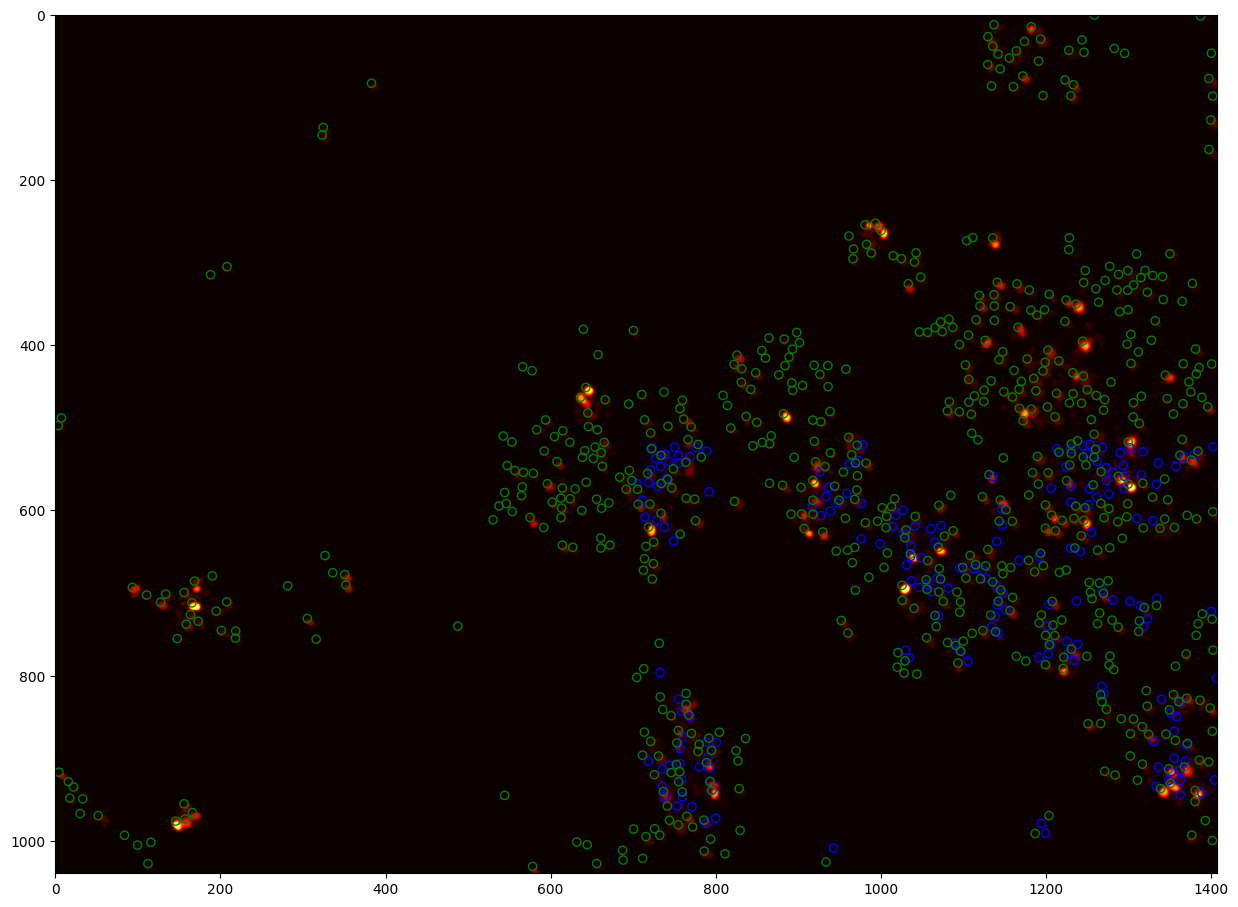

In [183]:
i = 90
fig, ax = plt.subplots(figsize=(15, 15))
ax.imshow(plt.imread(tif_arr[i-1]), cmap = 'hot')

d_cord = deep_cord[i]
imaris_cord = cord_imaris[i]

for item in d_cord:
    ax.add_patch(plt.Circle((item[0],item[1]), 5, color='b',fill=False))
for item in imaris_cord:
    ax.add_patch(plt.Circle((item[0]/1.24,item[1]/1.24), 5, color='g',fill=False))


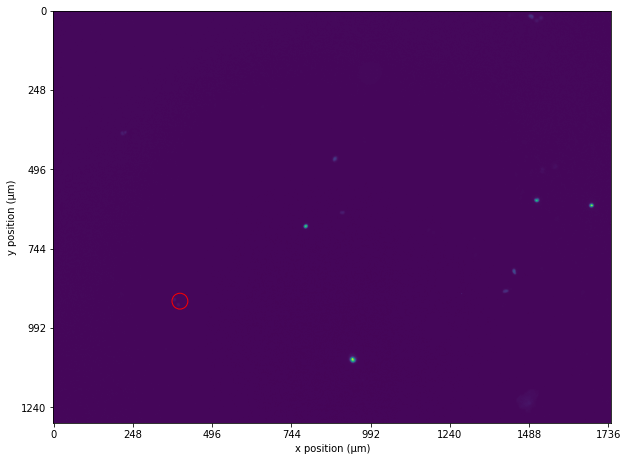

In [18]:
data = plt.imread(tif_arr[5])

pos = [395.1,908.38]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data)

formatter = lambda x, pos: f'{(x * 1.24):.0f}'
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('x position (μm)')
ax.set_ylabel('y position (μm)')

circle1 = plt.Circle((pos[0]/1.24, pos[1]/1.24), 20, color='r',fill=False)
ax.add_patch(circle1)

plt.show()

In [ ]:
np.load('C:\Projects\TAU\DL-Workshop\Images_Ilan\JH0011\Results\Segmentation\Segmentation\seg_tff_D2_1.npy')

<AxesSubplot:>

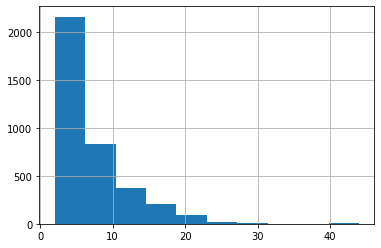

In [19]:
df_imaris.value_counts('Parent').hist()

In [20]:
df_imaris[df_imaris['Parent'] == 1000000003]

,Center of Image Mass X,Center of Image Mass Y,Center of Image Mass Z,Unit,Category,Channel,Collection,Time,Parent,ID
15,394.760010,908.189026,0.62,um,Surface,1,Center of Image Mass,6,1000000003,6
16,401.121002,905.005005,0.62,um,Surface,1,Center of Image Mass,7,1000000003,17
17,400.596008,903.445007,0.62,um,Surface,1,Center of Image Mass,8,1000000003,30
18,400.429993,921.361023,0.62,um,Surface,1,Center of Image Mass,10,1000000003,47
19,401.292999,927.791016,0.62,um,Surface,1,Center of Image Mass,11,1000000003,68
20,399.212006,931.593994,0.62,um,Surface,1,Center of Image Mass,12,1000000003,94
21,378.444000,902.328003,0.62,um,Surface,1,Center of Image Mass,15,1000000003,181
22,371.507996,900.697021,0.62,um,Surface,1,Center of Image Mass,16,1000000003,221
23,364.350006,902.546997,0.62,um,Surface,1,Center of Image Mass,17,1000000003,269
24,368.098999,899.382996,0.62,um,Surface,1,Center of Image Mass,18,1000000003,323


In [21]:
print(pos[0]/1.24, pos[1]/1.24)

318.6290322580645 732.5645161290323


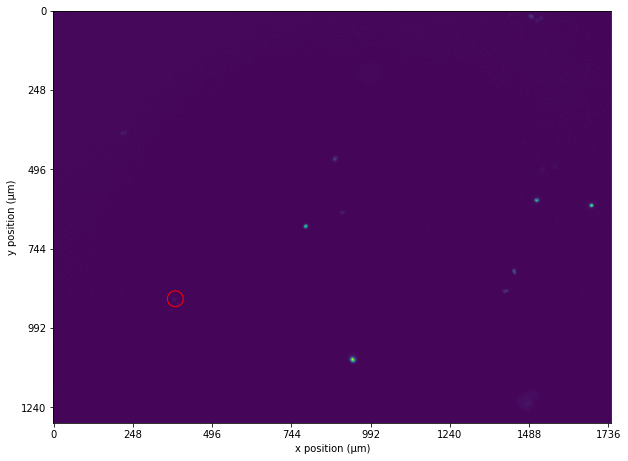

In [22]:
data = plt.imread(tif_arr[5])

pos = [395.1,908.38]
pos = deep_cord[3][-8]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(data)

formatter = lambda x, pos: f'{(x * 1.24):.0f}'
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)

ax.set_xlabel('x position (μm)')
ax.set_ylabel('y position (μm)')

circle1 = plt.Circle((pos[1], pos[0]), 20, color='r',fill=False)
ax.add_patch(circle1)

plt.show()

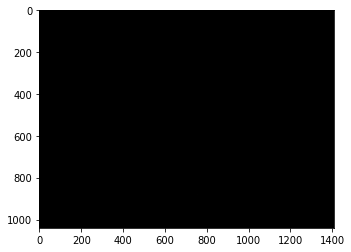

In [30]:
image = cv2.imread('C:\\Projects\\TAU\\DL-Workshop\\Images_Ilan\\JH0011\\TIF\\C-2_MK001_D2_1_2022y05m23d_17h00m.tif')


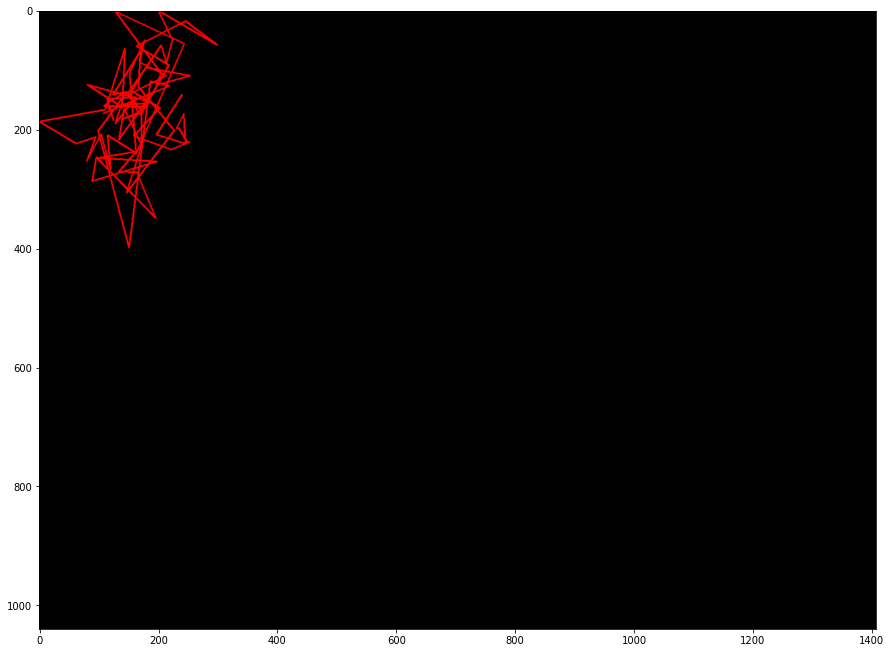

In [42]:
import cv2
import numpy as np
image = cv2.imread('C:\\Projects\\TAU\\DL-Workshop\\Images_Ilan\\JH0011\\TIF\\C-2_MK001_D2_1_2022y05m23d_17h00m.tif')

# List of points
points =list(df_d.loc[25,:].dropna())
# convert to numpy array and reshape
points = np.array(points)
points = [((points - points.min(axis = 0)) * 10)]
points = np.array(points)

points = points.reshape((-1, 1, 2))

# color, thickness and isClosed
color = (255, 0, 0)
thickness = 2
isClosed = False

# drawPolyline
image = cv2.polylines(image, np.int32([points]), isClosed, color, thickness)

fig, ax = plt.subplots(figsize=(15, 15))
# show image
ax.imshow(image, cmap= 'hot')


In [43]:
df_imaris[df_imaris['Parent'] == 1000000003]

,Center of Image Mass X,Center of Image Mass Y,Center of Image Mass Z,Unit,Category,Channel,Collection,Time,Parent,ID
15,394.760010,908.189026,0.62,um,Surface,1,Center of Image Mass,6,1000000003,6
16,401.121002,905.005005,0.62,um,Surface,1,Center of Image Mass,7,1000000003,17
17,400.596008,903.445007,0.62,um,Surface,1,Center of Image Mass,8,1000000003,30
18,400.429993,921.361023,0.62,um,Surface,1,Center of Image Mass,10,1000000003,47
19,401.292999,927.791016,0.62,um,Surface,1,Center of Image Mass,11,1000000003,68
20,399.212006,931.593994,0.62,um,Surface,1,Center of Image Mass,12,1000000003,94
21,378.444000,902.328003,0.62,um,Surface,1,Center of Image Mass,15,1000000003,181
22,371.507996,900.697021,0.62,um,Surface,1,Center of Image Mass,16,1000000003,221
23,364.350006,902.546997,0.62,um,Surface,1,Center of Image Mass,17,1000000003,269
24,368.098999,899.382996,0.62,um,Surface,1,Center of Image Mass,18,1000000003,323


In [45]:
df_imaris[df_imaris['Parent'] == 1000000003][['Center of Image Mass X','Center of Image Mass Y']].to_numpy()

array([[394.76000977, 908.18902588],
       [401.1210022 , 905.00500488],
       [400.5960083 , 903.44500732],
       [400.42999268, 921.36102295],
       [401.29299927, 927.79101562],
       [399.21200562, 931.59399414],
       [378.44400024, 902.32800293],
       [371.50799561, 900.69702148],
       [364.3500061 , 902.54699707],
       [368.09899902, 899.38299561],
       [368.62200928, 900.59698486]])

In [54]:
points = df_imaris[df_imaris['Parent'] == 1000000003][['Center of Image Mass X','Center of Image Mass Y']].to_numpy()
points = points/1.24

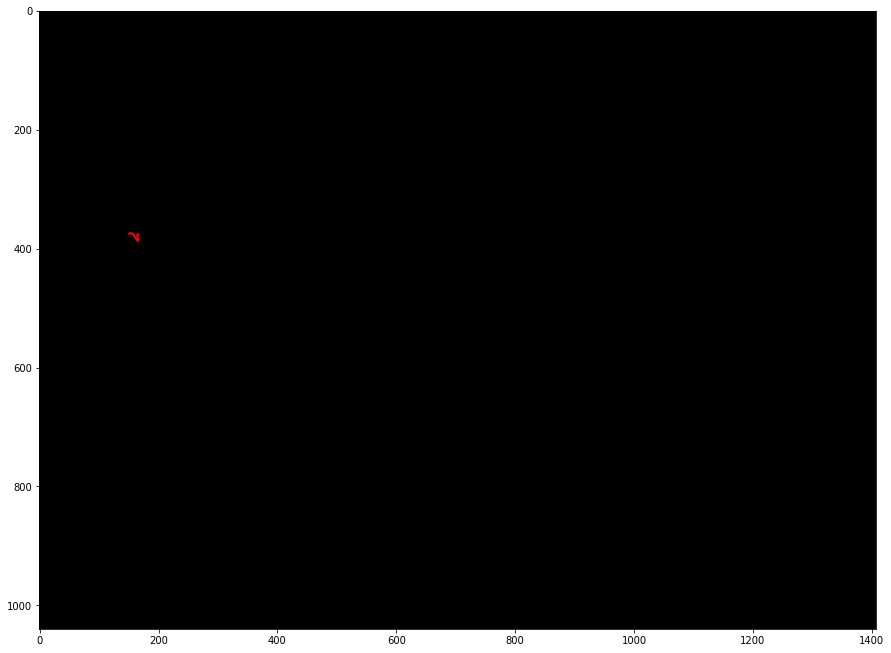

In [59]:
import cv2
import numpy as np
image = cv2.imread('C:\\Projects\\TAU\\DL-Workshop\\Images_Ilan\\JH0011\\TIF\\C-2_MK001_D2_1_2022y05m23d_17h00m.tif')

# List of points
points = df_imaris[df_imaris['Parent'] == 1000000003][['Center of Image Mass X','Center of Image Mass Y']].to_numpy()
points = points/2.4
# convert to numpy array and reshape


points = points.reshape((-1, 1, 2))

# color, thickness and isClosed
color = (255, 0, 0)
thickness = 2
isClosed = False

# drawPolyline
image = cv2.polylines(image, np.int32([points]), isClosed, color, thickness)

fig, ax = plt.subplots(figsize=(15, 15))
# show image
ax.imshow(image, cmap= 'hot')
